In [1]:
from helper import load_shapefile
from helper import plot_shapefile
import fiona
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import matplotlib.pyplot as plt
import glob
import os
from rasterio.mask import mask
import geopandas as gpd
from rasterio.warp import calculate_default_transform, reproject, Resampling
import os
import numpy as np
from PIL import Image
import pickle

In [2]:
def list_satellite_files():
    '''Given a directory path, use glob module to find all 73 satellite
    files matching a search pattern
    
    Returns: List of filepaths
    '''

    base = './data/orthoimages/vol00'
    dirpaths = [base + '1/', base + '2/', base + '3/', base + '4/',
                base + '5/', base + '6/', base + '7/', base + '8/']
    search_criteria = '10seg*.tif'

    satellite_files = []
    for folder in dirpaths:
        fp = folder + search_criteria
        satellite_files += glob.glob(fp)

    return satellite_files

In [3]:
sat_files = list_satellite_files()
#left=541500.0, bottom=4171500.0, right=556500.0, top=4188000.0

def mosaic_files(sat_files, filename):

    out_file = './data/orthoimages/' + filename
    files_to_mosaic = []
    
    # Open each tile to be merged
    for fp in sat_files:
        src = rasterio.open(fp)
        files_to_mosaic.append(src)
    
    bbox= (541500.0, 4171500.0, 556500.0, 4188000.0)
    
    # Record tile size to keep full resolution of final image, mutiply
    # dimensions up by respective num of tiles in x and y direction.
    meta = src.meta
    print(meta)
    new_height = meta['height']*11
    new_width = meta['width']*10
    meta['height'] = new_height
    meta['width'] = new_width
    
    # Keep track of output affine transformation as we merge files
    mosaic, out_trans = merge(files_to_mosaic)
    meta['transform'] = out_trans

    out_meta = meta.copy()
    with rasterio.open(out_file, "w", **out_meta) as dest:
        dest.write(mosaic)
        
# mosaic_files(sat_files, 'small_sf.tif')

In [3]:
def view_satellite_tif(fp):
    '''Quick view of raster image with basic stats for inspection
    
    Args:
    fp: Path to raster image
    '''
    data = rasterio.open(fp)
    print(data.bounds)
    meta = data.meta
    height = meta['height']
    width = meta['width']
    
    print('Bands of our satellite image:')
    print(data.colorinterp)
    print(f'Image height: {height}')
    print(f'Image width: {width}')
    
    im = Image.open(fp)
    im = np.array(im)
    print(im.shape)
    f, ax = plt.subplots(figsize = (10,10))
    f.clear()
    plt.imshow(im[:,:,:3])
        
small_sf = './data/orthoimages/small_sf.tif'
full_sf = './data/orthoimages/sf_mosaic.tif'

# view_satellite_tif('./data/orthoimages/small_sf.tif')

In [5]:
def reprojection(in_fp, out_fp, dst_crs):
    '''In order to project a shapefile and raster image onto each other,
    we must get them to be in the same projection standard. This module
    will change the projection of a raster image to a new standard.
    
    Args:
    fp (str): Filepath including name to output new reprojected raster
    dst_crs (str): String specifies the output projection CRS (coordinate
    projection system) (e.g. 'EPSG:4269')
    
    Return:
    None - Will output new raster file with target CRS.
    '''
   
    with rasterio.open(fp) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(out_fp, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

# reprojection(full_sf, './data/orthoimages/sf_full_reproject.tif', dst_crs = 'EPSG:4269')

In [4]:
def mask_image(img, mask_polygon, out_fp):
    '''Outputs a raster image, masked to the area within a given polygon
    
    Args:
    img (str): Filepath to raster image to be masked (should be *.tif)
    mask_polygon (list): A list containing dictionary of polygon coordinates
                    to trim to. Usually fiona will provide these values from shapefiles
    out_fp (str): Filepath to output new masked raster
    
    Return: None; will output a masked raster file based on polygon inputs
    '''
    
    with rasterio.open(img) as src:
        out_image, out_transform = mask(src, mask_polygon, crop=True)
        out_meta = src.meta.copy()

    out_meta.update({'driver': 'GTiff',
                    'height': out_image.shape[1],
                    'width': out_image.shape[2],
                    'transform': out_transform})
    with rasterio.open(out_fp, 'w', **out_meta) as dest:
        dest.write(out_image)

In [ ]:
# Mask satellite images to our blockgroup
trimmed_sf = './data/coreshape/sf_blockgroup_trimmed.shp'
img = './data/orthoimages/sf_mosaic.tif'
with fiona.open(trimmed_sf, 'r') as shapefile:
    features = [feature['geometry'] for feature in shapefile]
out_fp = './data/orthoimages/sf_masked.tif'
# mask_image(img, features, out_fp)

In [ ]:
# For each blockgroup, we will use their respective geometries to mask out the area
# and output each area into a tif file with filename of the GEOID of the respective blockarea.

trimmed_sf = './data/coreshape/sf_blockgroup_trimmed.shp'
sf_masked = './data/orthoimages/sf_masked.tif'
img = './data/orthoimages/sf_mosaic.tif'
# For each blockgroup, we will further mask the area to work with
with fiona.open(trimmed_sf, 'r') as shapefile:
    features = [(feature['geometry'],feature['properties']) for feature in shapefile]

dir_files = os.listdir('./data/orthoimages/maskedblock/')
for f in features:
    geo, prop = f
    fn = str(prop['GEOID']) + '.tif'
    out_fp = './data/orthoimages/maskedblock/' + fn
    if fn not in dir_files:
        print(f'Masking for blockgroup with GEOID: {fn[:-4]}')
        mask_image(img, [geo], out_fp)

In [7]:
def inspect_pickle_images(fp):
    data = pickle.load(open(fp, 'rb'))
    data = np.reshape(data, (120,120))
    data = np.multiply(data, 255)
    
    f, ax = plt.subplots(figsize=(12,12))
    plt.imshow(data, cmap='gray')

BoundingBox(left=549498.6, bottom=4181643.9, right=549843.2999999999, top=4182021.9)
Bands of our satellite image:
<built-in method colorinterp of rasterio._io.RasterReader object at 0x7fcc6cd49f60>
Image height: 1260
Image width: 1149
(1260, 1149, 4)


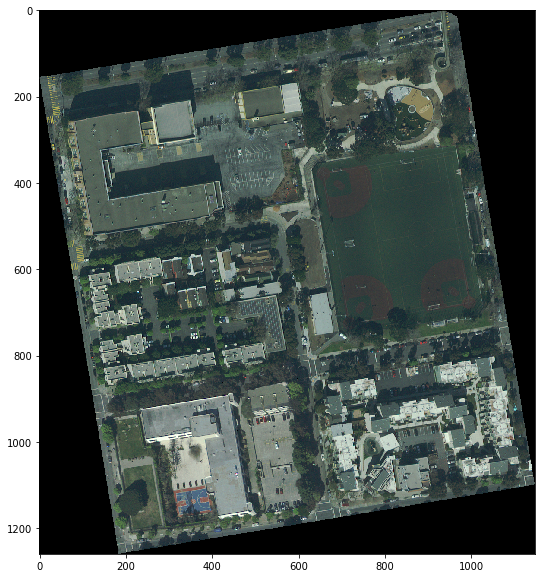

In [6]:
exclude1 = './data/orthoimages/maskedblock/060750328021.tif'
exclude2 = './data/orthoimages/maskedblock/060750332042.tif'
exclude3 = './data/orthoimages/maskedblock/060759802001.tif'
exclude4 = './data/orthoimages/maskedblock/060750126022.tif'
exclude5 = './data/orthoimages/maskedblock/060750129023.tif'
exclude6 = './data/orthoimages/maskedblock/060750158011.tif'


subwindow1 = './data/samples/060750328021/060750328021_3.pkl'
subwindow2 = './data/samples/060750332042/060750332042_4.pkl'
subwindow3 = './data/samples/060759802001/060759802001_6.pkl'
subwindow4 = './data/samples/060750126022/060750126022_1.pkl'
subwindow5 = './data/samples/060750158011/060750158011_7.pkl'

blockb = './data/orthoimages/maskedblock/060750107002.tif'
sampleb1 = './data/samples/060750107002/060750107002_1.pkl'
sampleb2 = './data/samples/060750107002/060750107002_2.pkl'
sampleb3 = './data/samples/060750107002/060750107002_3.pkl'
sampleb4 = './data/samples/060750111001/060750111001_3.pkl'
sampleb5 = './data/samples/060750111001/060750111001_4.pkl'

# view_satellite_tif('./data/orthoimages/sf_small_mosaic.tif')
view_satellite_tif(exclude6)
# inspect_pickle_images(sampleb1)